In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import rpy2
import pyarrow.dataset as ds
import pyarrow as pa
import pyarrow 
from pyarrow import csv
import rpy2_arrow.pyarrow_rarrow as pyra

In [2]:
## Change it to the location that you want to download your files to. 
%cd /Users/jonah/Documents/MDS/block_6/525-cloud-comp/group_19/DSCI_525_Group_19/

/Users/jonah/Documents/MDS/block_6/525-cloud-comp/group_19/DSCI_525_Group_19


In [3]:
# Necessary metadata
article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "rainfall/"

In [7]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  
files = data["files"]             

In [9]:
%%time
files_to_dl = ["data.zip"] 
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: user 2.89 s, sys: 9.08 s, total: 12 s
Wall time: 4min 22s


In [10]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: user 7.77 s, sys: 1.27 s, total: 9.04 s
Wall time: 9.4 s


In [11]:
%ls -ltr rainfall/

total 12048816
-rw-r--r--   1 jonah  staff  814041183 Mar 29 14:04 data.zip
-rw-r--r--   1 jonah  staff   95376895 Mar 29 14:12 MPI-ESM-1-2-HAM_daily_rainfall_NSW.csv
-rw-r--r--   1 jonah  staff   94960113 Mar 29 14:12 AWI-ESM-1-1-LR_daily_rainfall_NSW.csv
-rw-r--r--   1 jonah  staff   82474546 Mar 29 14:12 NorESM2-LM_daily_rainfall_NSW.csv
-rw-r--r--   1 jonah  staff  127613760 Mar 29 14:12 ACCESS-CM2_daily_rainfall_NSW.csv
-rw-r--r--   1 jonah  staff  232118894 Mar 29 14:12 FGOALS-f3-L_daily_rainfall_NSW.csv
-rw-r--r--   1 jonah  staff  330360682 Mar 29 14:12 CMCC-CM2-HR4_daily_rainfall_NSW.csv
-rw-r--r--   1 jonah  staff  254009247 Mar 29 14:12 MRI-ESM2-0_daily_rainfall_NSW.csv
-rw-r--r--   1 jonah  staff  235661418 Mar 29 14:12 GFDL-CM4_daily_rainfall_NSW.csv
-rw-r--r--   1 jonah  staff  294260911 Mar 29 14:12 BCC-CSM2-MR_daily_rainfall_NSW.csv
-rw-r--r--   1 jonah  staff  295768615 Mar 29 14:12 EC-Earth3-Veg-LR_daily_rainfall_NSW.csv
-rw-r--r--   1 jonah  staff  328852379 Mar 29 1

In [12]:
%%time
files = glob.glob('rainfall/*.csv')
files.remove("rainfall/observed_daily_rainfall_SYD.csv") # remove this csv for this step
df = pd.concat((pd.read_csv(file, index_col=0)
                .assign(model=re.findall("/([^_]*)", file)[0])
                for file in files)
              )
df.to_csv("rainfall/combined_data.csv")

CPU times: user 3min 18s, sys: 10.4 s, total: 3min 28s
Wall time: 3min 30s


In [13]:
%%time
# set lat/lon columns to float 32 and set model as a string
total_rain = pd.read_csv("rainfall/combined_data.csv", index_col=0, 
                         dtype={'lat_min': 'float32', 
                                'lat_max': 'float32',
                                'lon_min': 'float32',
                                'lon_max': 'float32',
                                 'model' : "str"
                                })
total_rain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62467843 entries, 1889-01-01 12:00:00 to 2014-12-31 12:00:00
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   lat_min        float32
 1   lat_max        float32
 2   lon_min        float32
 3   lon_max        float32
 4   rain (mm/day)  float64
 5   model          object 
dtypes: float32(4), float64(1), object(1)
memory usage: 2.3+ GB
CPU times: user 30.2 s, sys: 3.8 s, total: 34 s
Wall time: 35.5 s


In [14]:
%%time
# drop lat/lon cols
total_rain = total_rain.drop(columns=['lat_min','lat_max','lon_min','lon_max'])
total_rain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62467843 entries, 1889-01-01 12:00:00 to 2014-12-31 12:00:00
Data columns (total 2 columns):
 #   Column         Dtype  
---  ------         -----  
 0   rain (mm/day)  float64
 1   model          object 
dtypes: float64(1), object(1)
memory usage: 1.4+ GB
CPU times: user 478 ms, sys: 227 ms, total: 706 ms
Wall time: 710 ms


In [15]:
%%time
total_rain.head()

CPU times: user 81 µs, sys: 52 µs, total: 133 µs
Wall time: 120 µs


,rain (mm/day),model
time,,
1889-01-01 12:00:00,4.244226e-13,MPI-ESM-1-2-HAM
1889-01-02 12:00:00,4.217326e-13,MPI-ESM-1-2-HAM
1889-01-03 12:00:00,4.498125e-13,MPI-ESM-1-2-HAM
1889-01-04 12:00:00,4.251282e-13,MPI-ESM-1-2-HAM
1889-01-05 12:00:00,4.270161e-13,MPI-ESM-1-2-HAM


In [16]:
%%time
total_rain.describe(include="all")

CPU times: user 4.92 s, sys: 460 ms, total: 5.39 s
Wall time: 5.41 s


,rain (mm/day),model
count,5.924854e+07,62467843
unique,NaN,27
top,NaN,MPI-ESM1-2-HR
freq,NaN,5154240
mean,1.901170e+00,NaN
std,5.585735e+00,NaN
min,-3.807373e-12,NaN
25%,3.838413e-06,NaN
50%,6.154947e-02,NaN
75%,1.020918e+00,NaN


In [17]:
%%time
total_rain["model"].value_counts()

CPU times: user 1.93 s, sys: 21.2 ms, total: 1.95 s
Wall time: 1.95 s


MPI-ESM1-2-HR       5154240
CMCC-CM2-HR4        3541230
CMCC-ESM2           3541230
CMCC-CM2-SR5        3541230
NorESM2-MM          3541230
TaiESM1             3541230
SAM0-UNICON         3541153
GFDL-ESM4           3219300
FGOALS-f3-L         3219300
GFDL-CM4            3219300
MRI-ESM2-0          3037320
EC-Earth3-Veg-LR    3037320
BCC-CSM2-MR         3035340
MIROC6              2070900
ACCESS-CM2          1932840
ACCESS-ESM1-5       1610700
INM-CM4-8           1609650
INM-CM5-0           1609650
FGOALS-g3           1287720
KIOST-ESM           1287720
AWI-ESM-1-1-LR       966420
MPI-ESM1-2-LR        966420
NESM3                966420
MPI-ESM-1-2-HAM      966420
NorESM2-LM           919800
BCC-ESM1             551880
CanESM5              551880
Name: model, dtype: int64

In [2]:
%load_ext rpy2.ipython

In [3]:
filepathcsv = "/Users/sarahabdelazim/Desktop/MDS/Block_6/DSCI_525_web-cloud-comp/DSCI_525_Group_19/figsharerainfall/combined_data.csv"

In [4]:
%%time
dataset = ds.dataset(filepathcsv, format="csv")
# Converting the `pyarrow dataset` to a `pyarrow table`
table = dataset.to_table()
# Converting a `pyarrow table` to a `rarrow table`
r_table = pyra.converter.py2rpy(table)

CPU times: user 48 s, sys: 13.1 s, total: 1min 1s
Wall time: 1min 1s


In [6]:
%%R 
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))

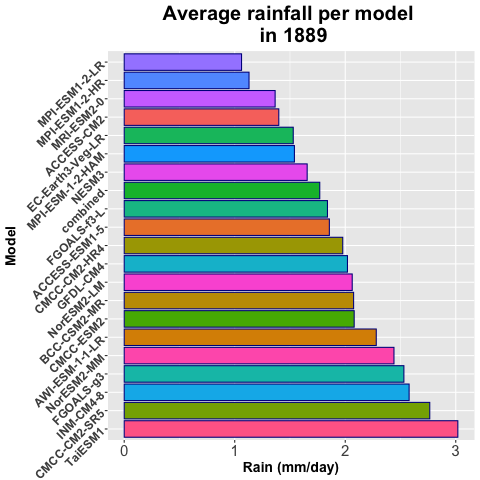

CPU times: user 1min 18s, sys: 32.4 s, total: 1min 50s
Wall time: 3min 23s


In [7]:
%%time
%%R -i r_table
df <- as.data.frame(r_table) %>%
    select(c(-lat_min, -lat_max, -lon_min, -lon_max)) %>%
    filter(year(time) == 1889) 

plot_rain <- df %>% 
    ggplot(aes(x = reorder(factor(model), -`rain (mm/day)`), y = `rain (mm/day)`, fill=model)) + 
    geom_bar(stat = "summary", fun = "mean", color="darkblue") + 
    labs(x="Model", y="Rain (mm/day)", title="Average rainfall per model \n in 1889") +
    theme(axis.title = element_text(size = 14, face = "bold"),
          plot.title = element_text(size = 20, face = "bold", hjust=0.5),
          axis.text.y = element_text(size = 12, angle = 45, vjust = 0.5, hjust=1, face="bold"),
          axis.text.x = element_text(size = 15),
          legend.position="none"
          ) +
    coord_flip()
    
plot_rain